# MLP Experiments on muvr data

First we need to setup the environment and import all the necessary stuff.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import shutil
import numpy as np
from os import remove
import cPickle as pkl
from os.path import expanduser, exists
import os
import sys
import logging

logging.basicConfig(level=10)
logger = logging.getLogger()

# Add the mlp python src director to the import search path
mlp_folder = "../python-analytics"
sys.path.append(os.path.abspath(mlp_folder))

# Now we are able to use all the packages defined in mlp_folder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This time we are not going to generate the data but rather use real world annotated training examples.

In [6]:
from muvr.dataset.acceleration_dataset import CSVAccelerationDataset
from muvr.dataset.labelmappers import generate_exercise_labelmapper

model_name = "arms"
working_directory = "ex-models"
dataset = CSVAccelerationDataset('datasets/Google Drive Exercises/', label_mapper=generate_exercise_labelmapper())

print "Number of training examples:", dataset.num_train_examples
print "Number of test examples:", dataset.num_test_examples
print "Number of features:", dataset.num_features
print "Number of labels:", dataset.num_labels

Number of training examples: 64045
Number of test examples: 13994
Number of features: 1200
Number of labels: 4


At first we want to inspect the class distribution of the training and test examples.

In [7]:
from ipy_table import *
from muvr.visualization.datastats import dataset_statistics
from operator import itemgetter

stats = dataset_statistics(dataset)

make_table(stats)
set_global_style(float_format='%0.0f', align="center")
set_column_style(0, align="left")
set_column_style(2, float_format='%0.2f%%')
set_column_style(4, float_format='%0.2f%%')
set_column_style(6, float_format='%0.2f%%')

,Train,Train %,Test,Test %,Overall,Overall %
arms/triceps-dips,1301,2.03%,424,3.03%,1725,2.21%
arms/triceps-extension,17460,27.26%,5300,37.87%,22760,29.16%
shoulders/lateral-raise,21850,34.12%,4620,33.01%,26470,33.92%
arms/biceps-curl,23434,36.59%,3650,26.08%,27084,34.71%


Let's have a look at the generated data. We will plot some of the examples of the different classes.

Ids of plotted examples: [17739 25555 46975]


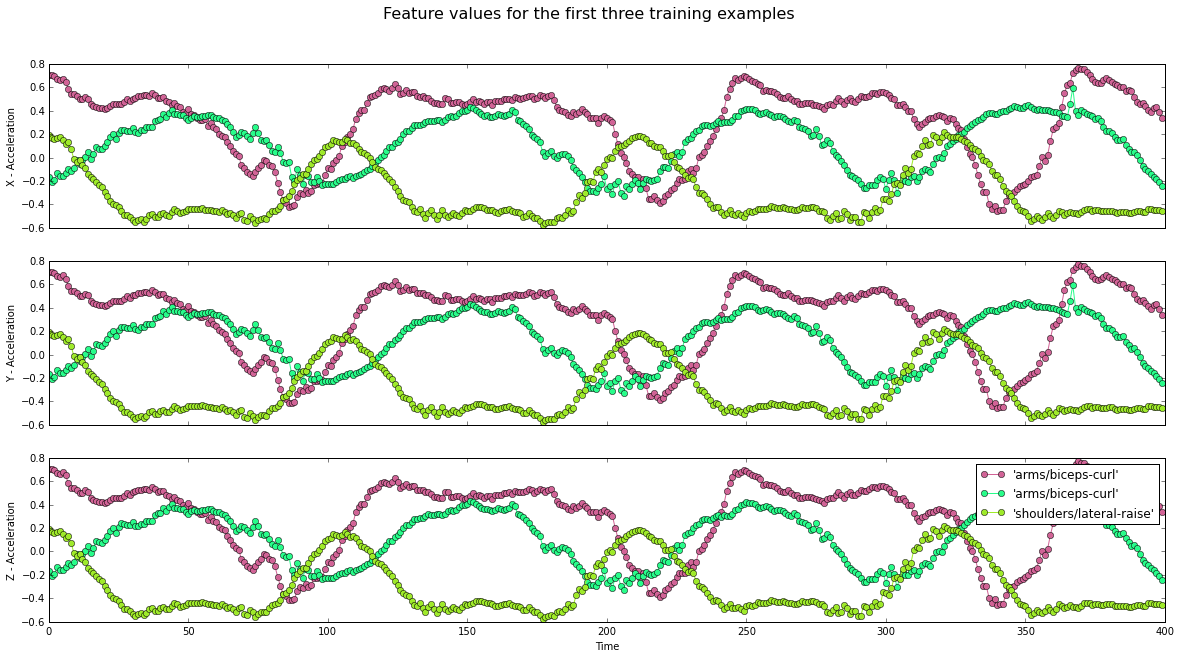

In [8]:
from muvr.visualization.example import plot_examples

# Choose some random examples to plot from the training data
number_of_examples_to_plot = 3
plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, number_of_examples_to_plot)

print "Ids of plotted examples:",plot_ids

figure = plot_examples(dataset, plot_ids)

Now we are going to create a neon model. We will start with a realy simple one layer preceptron having 500 hidden units.

In [10]:
from muvr.training.trainer import MLPMeasurementModelTrainer
from muvr.training.default_models import generate_default_exercise_model

mlpmodel = MLPMeasurementModelTrainer(
    working_directory, 
    lrate=0.001,
    max_epochs=10, 
    batch_size=128)

model = mlpmodel.train(dataset, generate_default_exercise_model(dataset.num_labels))

Epochs: 10 Batch-Size: 128
Starting training...
[1200, 'id', 250, 'relu', 50, 'relu', 4, 'logistic']
Epoch 0   [Train |████████████████████|  501/501  batches, 0.25 cost, 5.27s] [CrossEntropyMulti Loss 0.24, 0.28s]
Epoch 1   [Train |███████████████████ |  496/501  batches, 0.17 cost, 5.73s] [CrossEntropyMulti Loss 0.20, 0.44s]
Epoch 2   [Train |████████████████████|  501/501  batches, 0.24 cost, 5.90s] [CrossEntropyMulti Loss 0.19, 0.28s]
Epoch 3   [Train |███████████████████ |  494/501  batches, 0.15 cost, 5.47s] [CrossEntropyMulti Loss 0.18, 0.29s]
Epoch 4   [Train |███████████████████ |  496/501  batches, 0.15 cost, 6.05s] [CrossEntropyMulti Loss 0.18, 0.30s]
Epoch 5   [Train |████████████████████|  501/501  batches, 0.24 cost, 5.87s] [CrossEntropyMulti Loss 0.18, 0.31s]
Epoch 6   [Train |███████████████████ |  492/501  batches, 0.21 cost, 5.63s] [CrossEntropyMulti Loss 0.18, 0.30s]
Epoch 7   [Train |███████████████████ |  495/501  batches, 0.14 cost, 5.95s] [CrossEntropyMulti Loss 

To check weather the network is learning something we will plot the weight matrices of the different training epochs.

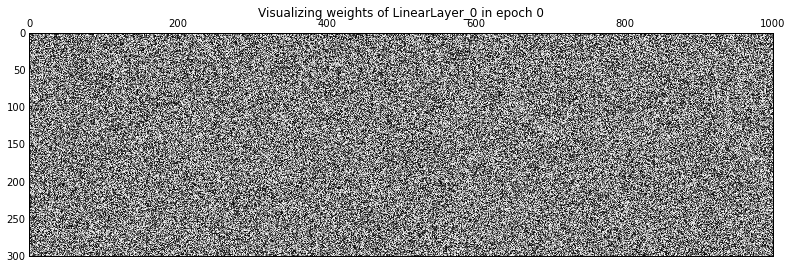

In [13]:
import numpy as np
import math
from matplotlib import pyplot, cm
from pylab import *
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import IntSlider

layer_names = map(lambda l: l[1].name+"_"+str(l[0]), filter(lambda l: l[1].has_params, enumerate(model.layers.layers)))

def closestSqrt(i):
    N = int(math.sqrt(i))
    while True:
        M = int(i / N)
        if N * M == i:
            return N, M
        
        N -= 1
        
def plot_filters(**kwargs):
    n = kwargs['n']
    layer_name = kwargs['layer']
    dest_path = os.path.join(working_directory, 'workout-mlp-ep_' + str(n))
    params = pkl.load(open(dest_path, 'r'))
    
    wts = params['layer_params_states'][layer_names.index(layer_name)]['params']['W']

    nrows, ncols = closestSqrt(wts.shape[0])
    fr, fc = closestSqrt(wts.shape[1])
    
    fi = 0

    W = np.zeros((fr*nrows, fc*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fc*col:fc*(col+1)] = wts[fi].reshape(fr,fc)
        fi = fi + 1

    matshow(W, cmap=cm.gray)
    title('Visualizing weights of '+layer_name+' in epoch ' + str(n) )
    show()

_i = interact(plot_filters,
              layer=widgets.widget_selection.ToggleButtons(options = layer_names),
              n=IntSlider(description='epochs',
                                        min=0, max=mlpmodel.max_epochs-1, value=0, step=1))

Let's visualize the error to see if the network has trained properly or if we are overfitting.

In [ ]:
import h5py
from neon.transforms import Misclassification

logged = h5py.File(os.path.join(working_directory, 'workout-mlp.h5'), "r")
epochs = logged['config'].attrs['total_epochs']
minibatches = logged['config'].attrs['total_minibatches']

print('Test error = %.1f%%'
      % (model.eval(dataset.test(), metric=Misclassification())*100))

print('Train error = %.1f%%'
      % (model.eval(dataset.train(), metric=Misclassification())*100))

print "Minibatches per epoch: %0.2f" % (minibatches * 1.0/epochs)

pyplot.plot(range(0, minibatches), logged['cost/train'], linewidth=3, label='train')
pyplot.plot(range(minibatches / epochs, minibatches, minibatches / epochs -1), logged['cost/loss'], linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("minibatch")
pyplot.ylabel("cost")
pyplot.show()

Let's also have a look at the confusion matrix for the test dataset.

In [14]:
from sklearn.metrics import confusion_matrix
from ipy_table import *

def predict(model, dataset):
    running_error = 0.0
    nprocessed = 0
    dataset.reset()
    predictions = np.empty((4, 0), dtype="float32")
    nprocessed = 0
    for x, t in dataset:
        pred = model.fprop(x, inference=True).asnumpyarray()
        bsz = min(dataset.ndata - nprocessed, model.be.bsz)
        nprocessed += bsz
        predictions = np.hstack((predictions, pred[:,:bsz]))
    return predictions

# confusion_matrix(y_true, y_pred)
predicted = predict(model, dataset.test())

y_true = dataset.y_test
y_pred = np.argmax(predicted, axis = 0) 

confusion_mat = confusion_matrix(y_true, y_pred, range(0,dataset.num_labels))

# Fiddle around with cm to get it into table shape
confusion_mat = vstack((np.zeros((1,dataset.num_labels), dtype=int), confusion_mat))
confusion_mat = hstack((np.zeros((dataset.num_labels + 1, 1), dtype=int), confusion_mat))

table = confusion_mat.tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[0][i+1] = s
    table[i+1][0] = s

table[0][0] = "actual \ predicted"

mt = make_table(table)
set_row_style(0, color='lightGray', rotate = "315deg")
set_column_style(0, color='lightGray')
set_global_style(align='center')

for i in range(1, dataset.num_labels + 1):
    for j in range(1, dataset.num_labels + 1):
        if i == j:
            set_cell_style(i,j, color='lightGreen', width = 80)
        elif table[i][j] > 20:
            set_cell_style(i,j, color='Pink')
        elif table[i][j] > 0:
            set_cell_style(i,j, color='lightYellow')
mt

actual \ predicted,shoulders/lateral-raise,arms/biceps-curl,arms/triceps-extension,arms/triceps-dips
shoulders/lateral-raise,4620,0,0,0
arms/biceps-curl,0,3650,0,0
arms/triceps-extension,0,0,5300,0
arms/triceps-dips,0,424,0,0


In [ ]:
from converters import neon2iosmlp

dataset.save_labels(os.path.join(working_directory, model_name + '_model.labels.txt'))
neon2iosmlp.convert(mlpmodel.model_path, os.path.join(working_directory, model_name + '_model.weights.raw'))

layers = mlpmodel.layers(dataset, model)
neon2iosmlp.write_layers_to_file(layers, os.path.join(working_directory, model_name + '_model.layers.txt'))